In [1]:
from sklearn.utils import shuffle
from tensorflow import keras
from keras.datasets import cifar10
import os
import time
import numpy as np
# Library for plot the output and save to file                                  
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt


import math
from pycuda import gpuarray
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import pycuda.autoinit


In [11]:
%matplotlib inline

In [2]:
baseDir = os.path.dirname(os.path.abspath('__file__')) + '/'
classesName = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(xTrain, yTrain), (xTest, yTest) = cifar10.load_data()
xVal = xTrain[49000:, :].astype(np.float)
yVal = np.squeeze(yTrain[49000:, :])
xTrain = xTrain[:49000, :].astype(np.float)
yTrain = np.squeeze(yTrain[:49000, :])
yTest = np.squeeze(yTest)
xTest = xTest.astype(np.float)


# Normalize the data by subtract the mean image                                 
meanImage = np.mean(xTrain, axis=0)
xTrain -= meanImage

xVal -= meanImage
xTest -= meanImage

# Reshape data from channel to rows                                             
xTrain = np.reshape(xTrain, (xTrain.shape[0], -1))
xVal = np.reshape(xVal, (xVal.shape[0], -1))
xTest = np.reshape(xTest, (xTest.shape[0], -1))
# Add bias dimension columns                                                    
xTrain = np.hstack([xTrain, np.ones((xTrain.shape[0], 1))])
xVal = np.hstack([xVal, np.ones((xVal.shape[0], 1))])
xTest = np.hstack([xTest, np.ones((xTest.shape[0], 1))])


class Svm (object):
    """" Svm classifier """
    # (xTrain.shape[1], numClasses)
    def __init__ (self, inputDim, outputDim):
        self.W = None
        sigma =0.01
        self.W = sigma * np.random.randn(inputDim,outputDim)


    def sgd (self, xTrain, yTrain, learning_rate, reg_strength, max_epochs=200, batchSize=200, verbose=False):
        # train model with cuda
        Loss = []        
        length_of_features = xTrain.shape[1]
        dim0 = 32
        block_dim = (10, dim0, 1)
        #grid_dim = (1, math.ceil(length_of_features/dim0), 1)
        grid_dim = (1, 1, 1)
        prg_sgd = SourceModule(open("../kernels/sgd_cifar_single_blk_normal_mult.cu", "r").read())
        func = prg_sgd.get_function("sgd")
        weights = self.W.astype(np.float32)
        time_gpu = 0
        s = time.time()
        dot_XW = np.zeros(10).astype(np.float32)
        DW = np.zeros((length_of_features,10)).astype(np.float32)
        loss = np.zeros(1)
        for i in range(max_epochs):
            num_train = np.random.choice(xTrain.shape[0], batchSize)
            xBatch = xTrain[num_train] # xBatch is a 2D array, each row is a data point,
            yBatch = yTrain[num_train]
            # Transfer variables onto device
            _start = cuda.Event()
            _end = cuda.Event()
            _start.record()            
            d_x = gpuarray.to_gpu(xBatch.astype(np.float32))
            d_y = gpuarray.to_gpu(yBatch.astype(np.float32))
            d_weights = gpuarray.to_gpu(self.W.astype(np.float32))
            d_single_dw = gpuarray.to_gpu(DW)
            d_dot_XW = gpuarray.to_gpu(dot_XW)
            d_loss = gpuarray.to_gpu(loss.astype(np.float32))
            func(d_x, d_y, d_weights, d_single_dw,
                 np.float32(reg_strength),
                 np.float32(learning_rate),
                 np.int32(batchSize),
                 d_dot_XW,
                 d_loss,
                 block=block_dim,
                 grid=grid_dim)
            
            _end.record()
            _end.synchronize()
            self.W = d_weights.get()
            Loss.append(d_loss.get())
            time_gpu +=   _start.time_till(_end) # in ms
        return Loss
            
            
            

            
        #################

    
    
    def predict (self, x,):
        yPred = np.zeros(x.shape[0])
        s = x.dot(self.W)
        yPred = np.argmax(s, axis=1)
        return yPred
    
    def calAccuracy (self, x, y):
        acc = 0
        yPred = self.predict(x)
        acc = np.mean(y == yPred)*100
        return acc


In [3]:
numClasses = np.max(yTrain) + 1
classifier = Svm(xTrain.shape[1], numClasses)

    



In [4]:
startTime = time.time()
classifier.sgd(xTrain, yTrain,
                    learning_rate=1e-7,
                    reg_strength=5e4,
                    max_epochs=500,
                    batchSize=200, verbose=True)

[array([154768.42], dtype=float32),
 array([152305.14], dtype=float32),
 array([149657.27], dtype=float32),
 array([150195.12], dtype=float32),
 array([148275.53], dtype=float32),
 array([161082.84], dtype=float32),
 array([168825.45], dtype=float32),
 array([176031.69], dtype=float32),
 array([180228.7], dtype=float32),
 array([229836.88], dtype=float32),
 array([270018.03], dtype=float32),
 array([370118.44], dtype=float32),
 array([491669.53], dtype=float32),
 array([615338.56], dtype=float32),
 array([608062.56], dtype=float32),
 array([638584.2], dtype=float32),
 array([788674.7], dtype=float32),
 array([945886.75], dtype=float32),
 array([1555909.8], dtype=float32),
 array([2465682.2], dtype=float32),
 array([2257794.], dtype=float32),
 array([2592072.2], dtype=float32),
 array([2364723.5], dtype=float32),
 array([2519468.5], dtype=float32),
 array([3221754.5], dtype=float32),
 array([3809561.8], dtype=float32),
 array([3717561.5], dtype=float32),
 array([3915344.8], dtype=float3

In [7]:
print ("max_epochs = 500\n")
#print('Training time: {0}'.format(time.time() - startTime))
print ('Training acc:   {0}%'.format(classifier.calAccuracy(xTrain, yTrain)))
#    print ('Validating acc: {0}%'.format(classifier.calAccuracy(xVal, yVal)))
print ('Testing acc:    {0}%'.format(classifier.calAccuracy(xTest, yTest)))

max_epochs = 500

Training acc:   11.973469387755102%
Testing acc:    12.19%


In [15]:
# Training classifier

t = []
acc_tr = []
acc_te = []
loss_a = []

itr = 50
for i in range(itr):
    max_iter = (i+1) * 10
    startTime = time.time()
    Loss = classifier.sgd(xTrain, yTrain,
                          learning_rate=1e-7,
                          reg_strength=5e4,
                          max_epochs=max_iter,
                          batchSize=200, verbose=True)
    endTime = time.time()
    loss_a.append(Loss[0])
    #print(loss_a)
    #print ("max_epochs = ", max_iter, "\n")
    #print ('Training time: {0}'.format(endTime - startTime))
    #print ('Training acc:   {0}%'.format(classifier.calAccuracy(xTrain, yTrain)))
    #    print ('Validating acc: {0}%'.format(classifier.calAccuracy(xVal, yVal)))
    #print ('Testing acc:    {0}%'.format(classifier.calAccuracy(xTest, yTest)))
    t.append(endTime - startTime)
    acc_tr.append(classifier.calAccuracy(xTrain, yTrain))
    acc_te.append(classifier.calAccuracy(xTest, yTest))



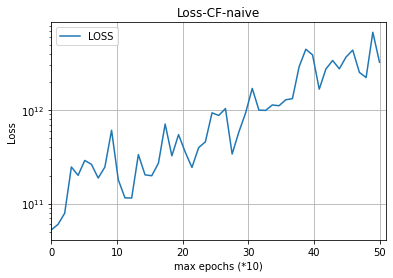

In [16]:
### print loss with max_epochs ####
x = np.linspace(0, itr, itr)
fig, ax = plt.subplots()
line1, = ax.plot(x, loss_a, label='LOSS')
ax.set_title('Loss-CF-naive')
ax.set_xlabel('max epochs (*10)')
ax.set_ylabel('Loss')
ax.set_yscale('log')
ax.grid(True)
ax.set_xlim(0, itr + 1)
ax.xaxis.set_ticks(np.arange(0,itr + 1, 10))
ax.legend()
plt.savefig("../result-plots/CF-Naive-Loss.png")

plt.show()

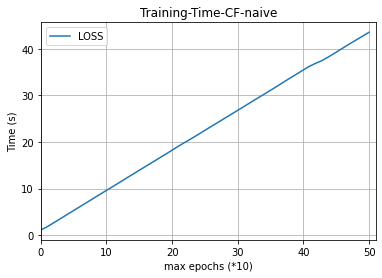

In [17]:
### print time with max_epochs ####
x0 = np.linspace(0, itr, itr)
fig0, ax0 = plt.subplots()
line1, = ax0.plot(x0, t, label='LOSS')
ax0.set_title('Training-Time-CF-naive')
ax0.set_xlabel('max epochs (*10)')
ax0.set_ylabel('Time (s)')
#ax0.set_yscale('log')
ax0.grid(True)
ax0.set_xlim(0, itr + 1)
ax0.xaxis.set_ticks(np.arange(0,itr + 1, 10))
ax0.legend()
plt.savefig("../result-plots/CF-Naive-Time.png")



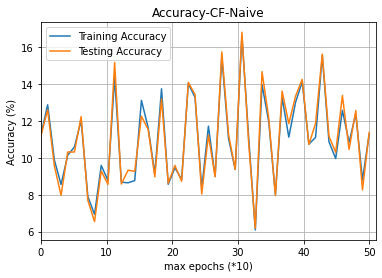

In [18]:
### print accuracy on test and train with max_epochs ###

x1 = np.linspace(0, itr, itr)
fig1, ax1 = plt.subplots()
line1, = ax1.plot(x1, acc_tr, label='Training Accuracy')
line1, = ax1.plot(x1, acc_te, label='Testing Accuracy')
ax1.set_title('Accuracy-CF-Naive')
ax1.set_xlabel('max epochs (*10)')
ax1.set_ylabel('Accuracy (%)')

ax1.grid(True)
ax1.set_xlim(0, itr + 1)
ax1.xaxis.set_ticks(np.arange(0,itr + 1, 10))
ax1.legend()
plt.savefig("../result-plots/CF-Naive-Accuracy.png")